# Isabelle Geller: Assignment 2

In [27]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

#### Step 1: load data from file

In [28]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

data = pd.read_csv('ecg_data_nan.csv', sep=',')

#### Step2: check and handle missing values

In [29]:
data.interpolate(method='linear', axis=0, inplace=True)
data = data['Amp'].values

#### Step3: plot the signal

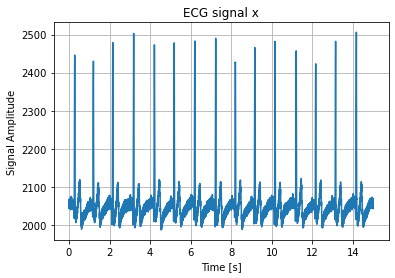

In [30]:
f=1.0
fs = 1000 # sampling rate (Hz)
Ts = 1/fs # sampling intervel (seconds)
N = data.shape[0] # total number of data points in the ECG signal x
Duration= N/fs #seconds
Duration

# time points
t = np.linspace(0, Duration-Ts, N) #array of time points
x = t #x axis is the time in seconds
y = data #y axis is the apmplitude or the value in each row of the data we parsed

#plotting
fig, ax = plt.subplots()
ax.plot(x, y, linestyle='-')
ax.set_title('ECG signal x')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal Amplitude')
ax.grid(True)



#### Step4: smooth the signal using cross-correlation with Gaussian Kernel (remove noise and may need to adjust kernel parameter)
#tg = gaussian timepoints so that is on the xaxis

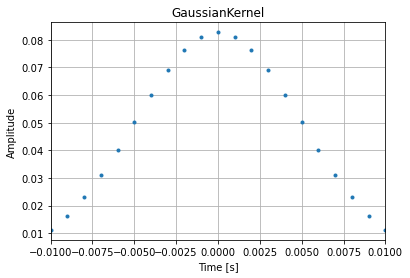

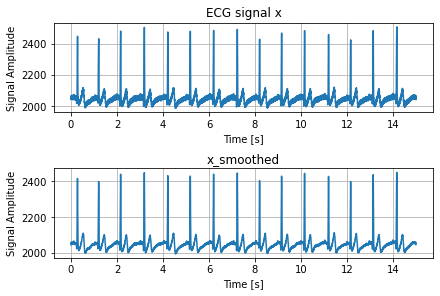

In [31]:
tg = np.linspace(-0.01, 0.01, 21)
sigma= 0.005
GaussianKernel = np.exp(-tg**2/(2*sigma**2))
GaussianKernel/=GaussianKernel.sum()
import scipy.stats as st

#plot the kernel
fig, ax = plt.subplots()
ax.plot(tg, GaussianKernel, '.')
ax.set_title('GaussianKernel')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude')
ax.grid(True)
ax.set_xlim([-.01, .01])

#cross correlate to get the smoothed version
from scipy.ndimage import correlate

y_smooth = correlate(y, GaussianKernel, mode='nearest')


fig, ax = plt.subplots(2, 1, constrained_layout=True)
ax[0].plot(x, y, linestyle='-')
ax[0].set_title('ECG signal x')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Signal Amplitude')
ax[0].grid(True)

ax[1].plot(x, y_smooth, linestyle='-')
ax[1].set_title('x_smoothed')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Signal Amplitude')
ax[1].grid(True)



#### Step5: detect peaks

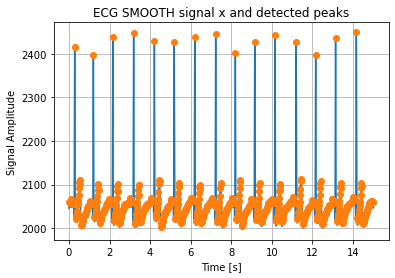

In [35]:
def peakDetector(q):
    h1 = [-1, 1, 0]
    h2 = [0, 1, -1]
    y = correlate(q, h1, mode='nearest')
    z = correlate(q, h2, mode='nearest')
    indexArr1 = np.where(y>0) #find pos index in y
    indexArr2 = np.where(z>0)
    peakIndexArr = np.intersect1d(indexArr1, indexArr2)
    return peakIndexArr

smoothPeakIndexArr = peakDetector(y_smooth)

fig, ax = plt.subplots()
ax.plot(x, y_smooth, '-')
ax.plot(x[smoothPeakIndexArr], y_smooth[smoothPeakIndexArr], 'o')
ax.set_title('ECG SMOOTH signal x and detected peaks')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal Amplitude')
ax.grid(True)

#### Step6: peak selection and visualization

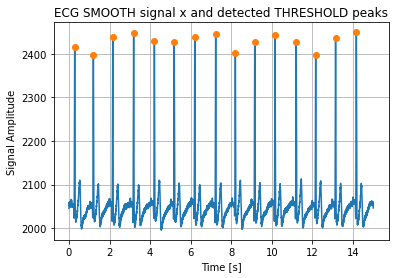

In [38]:
threshold = 2300

aboveThresholdSmooth = y_smooth[smoothPeakIndexArr] >= threshold
thresholdPeakSmooth = smoothPeakIndexArr[aboveThresholdSmooth]


fig, ax = plt.subplots()
ax.plot(x, y_smooth, '-')
ax.plot(x[thresholdPeakSmooth], y_smooth[thresholdPeakSmooth], 'o')
ax.set_title('ECG SMOOTH signal x and detected THRESHOLD peaks')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal Amplitude')
ax.grid(True)

#### Step7: calculate heart rate per minute based on the R-peaks

######### [ 0.284  1.204  2.159  3.189  4.211  5.188  6.201  7.232  8.2    9.158
 10.156 11.198 12.159 13.14  14.163]
######### [0.92  0.955 1.03  1.022 0.977 1.013 1.031 0.968 0.958 0.998 1.042 0.961
 0.981 1.023]


ValueError: x and y must have same first dimension, but have shapes (15,) and (14,)

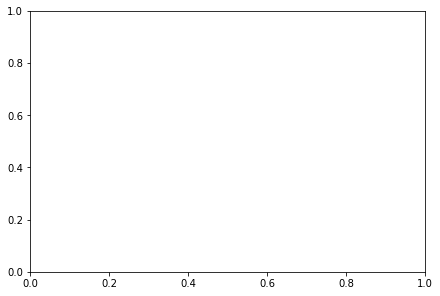

In [41]:
# noise
fig, ax = plt.subplots(constrained_layout=True)
# ax[0].plot(x, y, '-')
# print('****', thresholdPeakNoise)
# ax[0].plot(x[thresholdPeakNoise], y[thresholdPeakNoise], 'o')
# # ax[0].set_title('ECG NOISE signal x and detected THRESHOLD peaks')
# ax[0].set_xlabel('Time [s]')
# ax[0].set_ylabel('Signal Amplitude')
# ax[0].grid(True)
# print()

bpm_time_pointsSmooth = x[thresholdPeakSmooth]
print('#########', bpm_time_pointsSmooth)

r_intervalsNoise = np.diff(bpm_time_pointsSmooth)
print('#########', r_intervalsNoise)

bpm_valuesSmooth = 60 / r_intervalsNoise
bpm_values = np.insert(bpm_valuesSmooth, 0, bpm_valuesSmooth[0])
#signal decomposition: try additive and multiplicative
# result = seasonal_decompose(x, model='additive', freq= int(fs/f))
# trend = result.trend
# seasonal = result.seasonal
# residual = result.residual

ax.plot(bpm_time_pointsSmooth,bpm_valuesSmooth, '-');
ax.axis([0, Duration, 0, 100])

# ax[1].plot(x, y_smooth, linestyle='-')
# ax[1].set_title('x_smoothed')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Heart Rate per minute')
ax.grid(True)
#
#
# # smooth
# fig, ax = plt.subplots(2, 1, constrained_layout=True)
# ax[1].plot(x, y, linestyle='-')
# ax[1].set_title('ECG signal x')
# ax[1].set_xlabel('Time [s]')
# ax[1].set_ylabel('Signal Amplitude')
# ax[1].grid(True)
#
# ax[0].plot(x, y_smooth, linestyle='-')
# ax[0].set_title('x_smoothed')
# ax[0].set_xlabel('Time [s]')
# ax[0].set_ylabel('Signal Amplitude')
# ax[0].grid(True)


In [ ]:
# data[data.notnull()]

In [ ]:
f=10 #signal frequence
fs = 1000 # sampling rate (Hz)
Ts = 1/fs # sampling intervel (seconds)
N = data.shape[0] # total number of data points in the ECG signal x
Duration= N/fs #seconds

# time points
t = np.linspace(0, Duration-Ts, N) #array of time points
pi = np.pi
x= np.sin(2*pi*f*t) #sin signal

x.shape #1000sig values
t.shap # 1000 data points

fig, ax = plt.subplots()
ax.plot(t, x, '-')

In [ ]:
print(Duration)
Duration
